In [1]:
import os
import io
import numpy as np
from PIL import Image
import fitz
import re

from faster_rcnn import BradOCR, plot_text_xyxy
from ocr_post_process import group_text_into_line, find_single_passage

nt


- load model

In [2]:
ocr_model = BradOCR(
    filepath_model_word=os.path.join(r'C:\Users\bomso\bomsoo1\python\_pytorch\pjt_faster_rcnn\trained\word\fasterrcnn_01010320_0.9651181492864416'), # resnet
    filepath_model_char=os.path.join(r'C:\Users\bomso\bomsoo1\python\_pytorch\pjt_faster_rcnn\trained\char\fasterrcnn_01270246_0.9668653988020294'),  # pjt_faster_rcnn_250126_OCR_CHAR3_0p5 vgg
    n_test_pre_nms=12000, n_test_post_nms=2000,
    label_names_char = list('''0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ~!@#$%^&*()_+-={}|[]\:";'<>?,./'''), # full except: `
)

>> reloaded_word['model_init_inputs'] = {'n_fg_class': 1, 'feat_stride': 16, 'loc_normalize_mean': (0.0, 0.0, 0.0, 0.0), 'loc_normalize_std': (0.1, 0.1, 0.2, 0.2), 'backbone_name': 'resnet101', 'use_pretrained_weights': True, 'freeze_param_up_to': 0, 'ceil_mode_for_MaxPool2d': True, 'always_freeze_first_batch_norm': False, 'use_untrained_vgg_classifier': False, 'base_size': 16, 'ratios': [0.25, 0.5, 1, 2, 4], 'anchor_scales': [0.25, 0.5, 1, 2, 4], 'y_offsets': [0], 'x_offsets': [0], 'nms_thresh': 0.7, 'n_train_pre_nms': 12000, 'n_train_post_nms': 2000, 'n_test_pre_nms': 12000, 'n_test_post_nms': 2000, 'min_size': 0, 'roi_size': 7, 'is_roi_align': True, 'roi_align_sampling_ratio': 2, 'roi_align_aligned': True}
>> reloaded_char['model_init_inputs'] = {'n_fg_class': 93, 'feat_stride': 16, 'loc_normalize_mean': (0.0, 0.0, 0.0, 0.0), 'loc_normalize_std': (0.1, 0.1, 0.2, 0.2), 'backbone_name': 'vgg16', 'use_pretrained_weights': True, 'freeze_param_up_to': 0, 'ceil_mode_for_MaxPool2d': True, 

- load image / detect text

[████████████████████████████████████████████████████████████] 22/22, elapsed time 01:33.8, estimated wait time 00:00.00



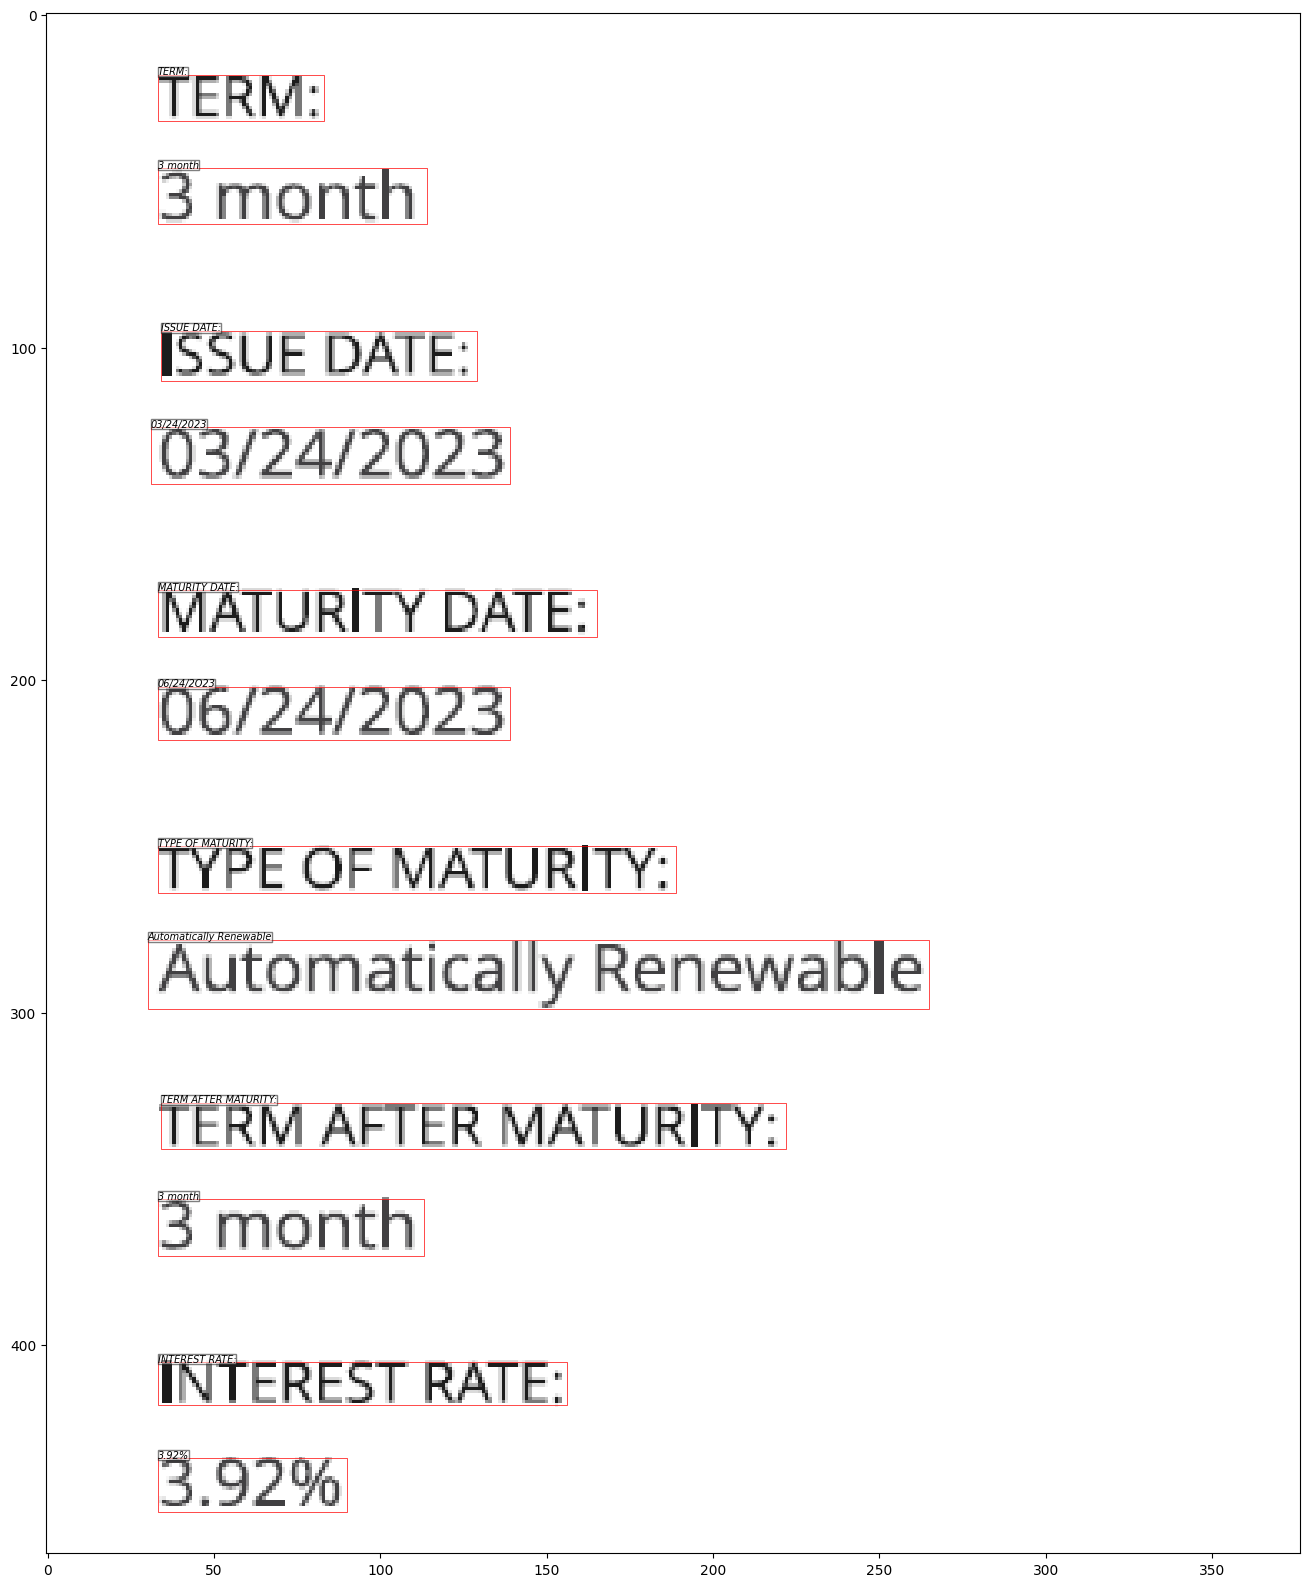

TERM:
3 month
ISSUE DATE:
03/24/2023
MATURITY DATE:
06/24/2O23
TYPE OF MATURITY:
Automatically Renewable
TERM AFTER MATURITY:
3 month
INTEREST RATE:
3.92%
[████████████████████████████████████████████████████████████] 379/379, elapsed time 29:09.4, estimated wait time 00:00.0



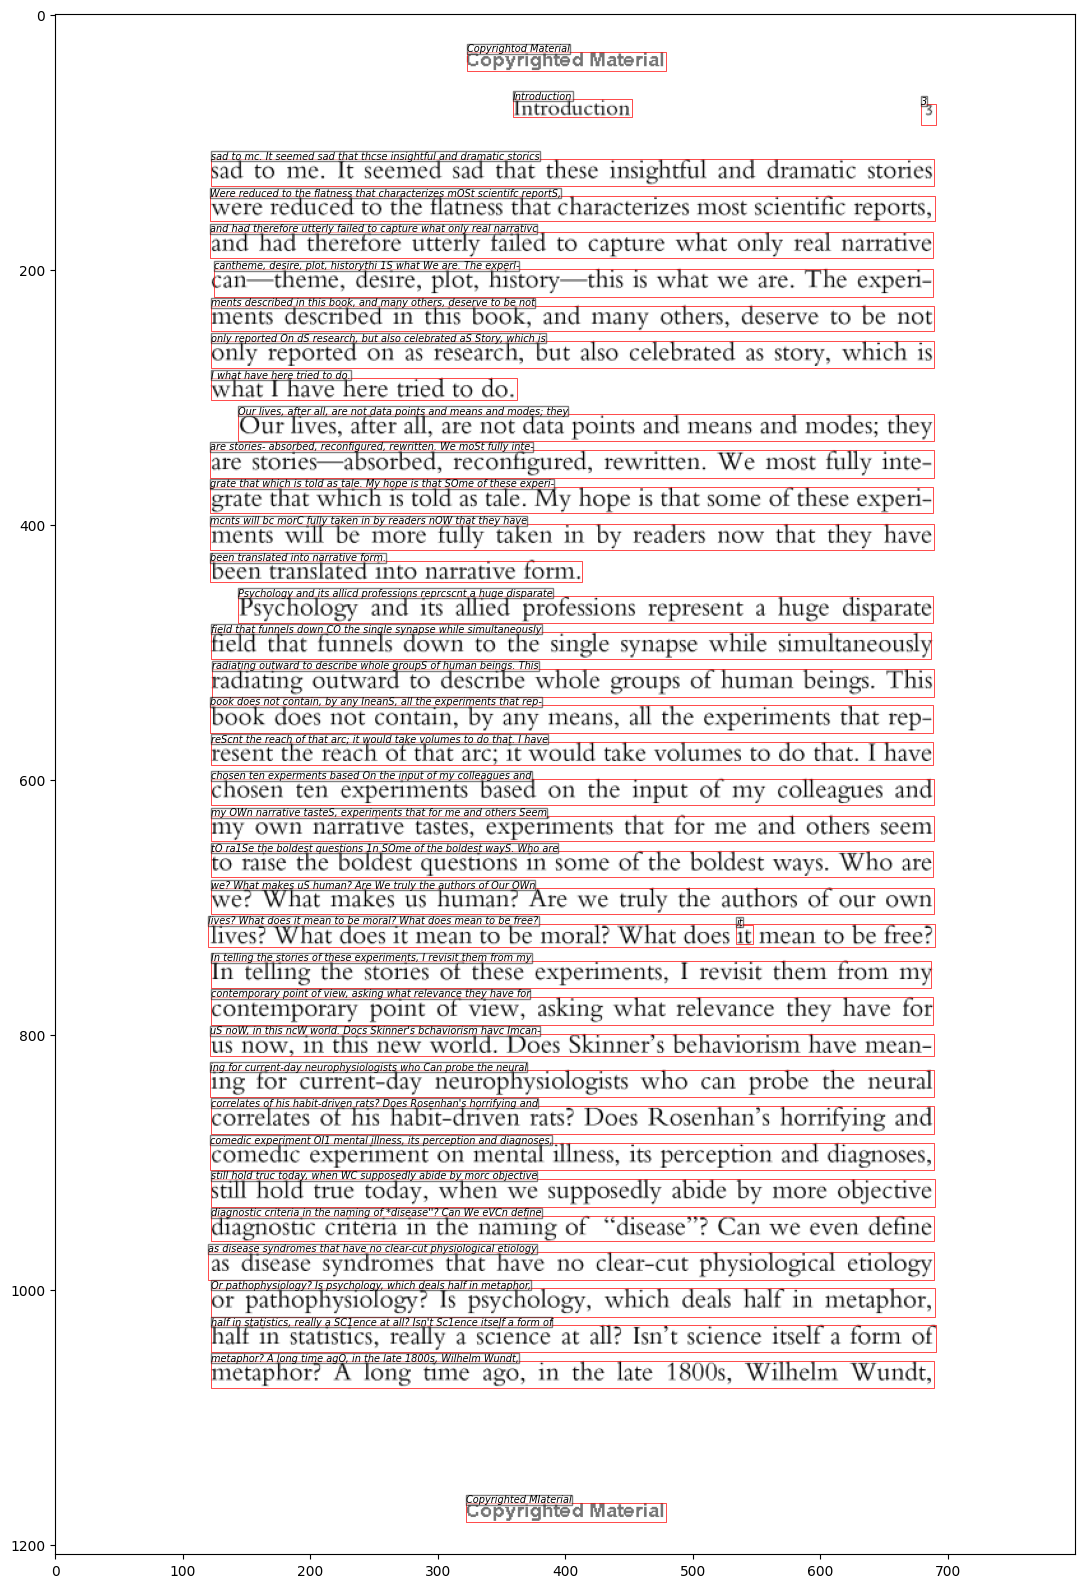

Copyrightod Material
Introduction	3
sad to mc. It seemed sad that thcse insightful and dramatic storics
Were reduced to the flatness that characterizes mOSt scientifc reportS,
and had therefore utterly failed to capture what only real narrativc
cantheme, desire, plot, historythi 1S what We are. The experl-
ments described in this book, and many others, deserve to be not
only reported On dS research, but also celebrated aS Story, which is
I what have here tried to do.
Our lives, after all, are not data points and means and modes; they
are stories- absorbed, reconfigured, rewritten. We moSt fully inte-
grate that which is told as tale. My hope is that SOme of these experi-
mcnts will bc morC fully taken in by readers nOW that they have
been translated into narrative form.
Psychology and its allicd professions reprcscnt a huge disparate
field that funnels down CO the single synapse while simultaneously
radiating outward to describe whole groupS of human beings. This
book does not contain,

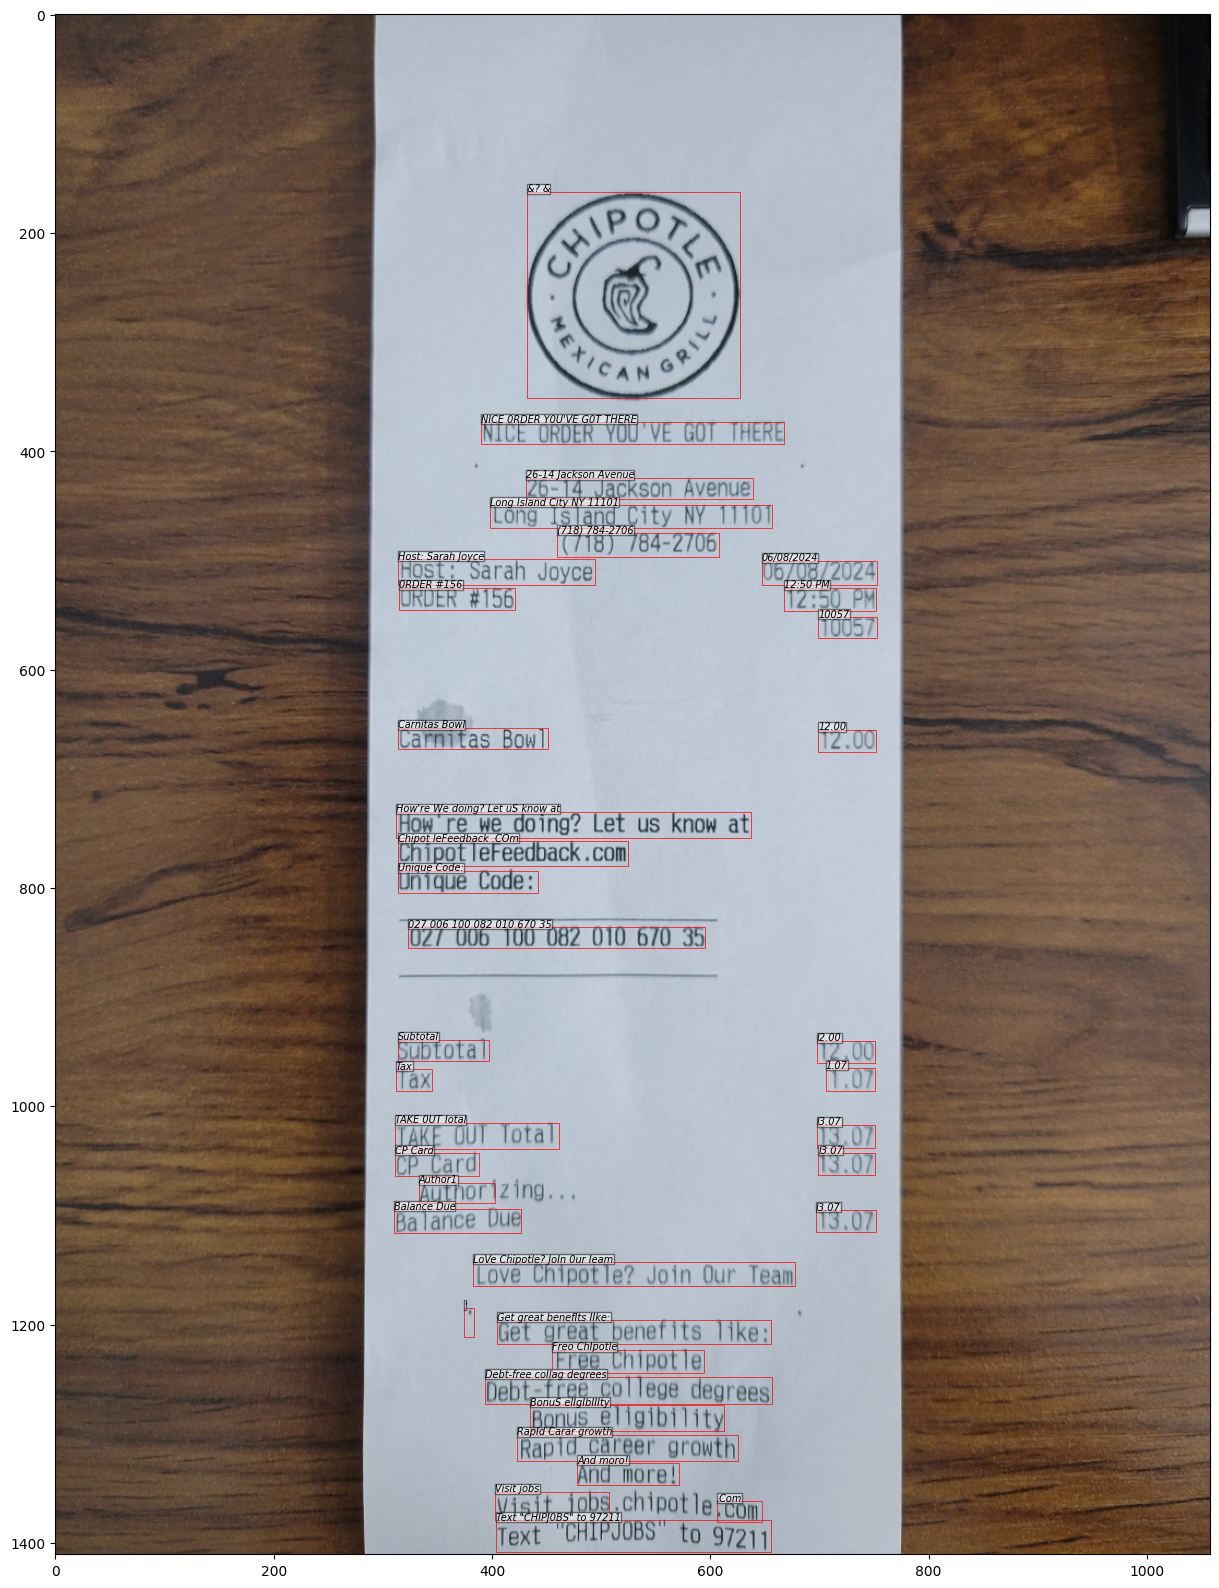

&? &
NICE 0RDER Y0U'VE G0T THERE
26-14 Jackson Avenue
Long Island City NY 11101
(718) 784-2706
Host: Sarah Joyce	06/08/2024
0RDER #156	12:50 PM
10057
Carnitas Bowl	12.00
How're We doing? Let uS know at
Chipot leFeedback .COm
Unique Code:
027 006 100 082 010 670 35
Subtotal	I2.00
Tax	1.07
TAKE 0UT Iotal	I3.07
CP Card	I3.07
Author1
Balance Due	I3.07
LoVe Chipotle? JoIn 0ur Ieam
'	Get great benefIts IIke:
Freo ChIpotle
Debt-free coIlag degrees
BonuS elIgIbIIIty
RapId Carar growth
And moro!
Visit jobs	.Com
Text "CHIPJ0BS" to 97211


In [5]:
for filepath in [
    r'images/pic05.png',
    r'images/opening_skinner.png',
    r'images/chipotle.jpg',
]:
    #--- load image ---------------------------------------------------
    if re.search('\.(jpg|png)$', filepath, re.IGNORECASE): # load image file
        image = Image.open(filepath)
        if image.mode != 'RGB':
            image = image.convert("RGB")
        img = np.array(image)
    elif re.search('\.pdf$', filepath, re.IGNORECASE): # load pdf file
        doc = fitz.open(os.path.join(filepath)) # Open the PDF document
        page = doc[0] # Get the first page
        # pix = page.get_pixmap(dpi=300) # Get the pixmap of the page
        pix = page.get_pixmap(dpi=150) # Get the pixmap of the page
        img_bytes = pix.tobytes() # Convert the pixmap to bytes
        img = np.array(Image.open(io.BytesIO(img_bytes))) # Open the image using PIL
    else:
        raise(Exception(f'Brad error: unknown file extension...'))

    #--- predict -----------------------------------------------------
    # out = {'pred_texts': [('PERMANENT', (95, 610, 187, 623)),.......
    out = ocr_model.predict(img, fix_img_H=100, debug=False)

    #--- post-process ------------------------------------------------
    list_text_xyxy = out['pred_texts']
    i_to_line_map, seqs, uid_to_word_map = group_text_into_line(list_text_xyxy, alpha=1.0, debug=False)
    passage, longlines = find_single_passage(seqs, uid_to_word_map, delimiter='\t')
    # passage, longlines = find_single_passage(seqs, uid_to_word_map, delimiter=';')

    #--- plot bounding box -------------------------------------------
    plot_text_xyxy(img, out['pred_texts'])
    # plot_text_xyxy(img, i_to_line_map.values())
    # plot_text_xyxy(img, passage)

    print('\n'.join(p[0] for p in passage)) # text extracted

